In [15]:
import numpy as np
import pandas as pd
np.random.seed(42)
import matplotlib.pyplot as plt
from hw1 import preprocess
from hw1 import compute_cost
from hw1 import gradient_descent
from hw1 import pinv
from hw1 import efficient_gradient_descent
from hw1 import find_best_alpha
from hw1 import generate_triplets
from hw1 import find_best_triplet

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 1: Linear Regression

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are provided with **some basic sanity checks**. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in the provided `hw1.py` python module only. All the logic you write is imported and used using this jupyter notebook.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports detected in `hw1.py` will earn you the grade of 0, even if you only used them for testing.
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Code that cannot run will also earn you the grade of 0.
7. Write your own code. Cheating will not be tolerated. 
8. Submission includes the `hw1.py` file and this notebook. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).

## In this exercise you will perform the following:
1. Load a dataset and perform basic data exploration using a powerful data science library called [pandas](https://pandas.pydata.org/pandas-docs/stable/).
2. Preprocess the data for linear regression.
3. Compute the cost and perform gradient descent in pure numpy in vectorized form.
4. Fit a linear regression model using a single feature.
5. Visualize your results using matplotlib.
6. Perform multivariate linear regression.
7. Pick the best three features in the dataset.


## Part 1: Data Preprocessing (10 Points)

For the following exercise, we will use a dataset containing housing prices in King County, USA. The dataset contains 21,613 obervations with 19 features and a single target value - the house price. 

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [16]:
# Read comma separated data
df = pd.read_csv('data/kc_house_data.csv') # Relative paths are better than absolute paths. Handle with care.
# df stands for dataframe, which is the default format for datasets in pandas

### Data Exploration
A good practice in any data-oriented project is to first try and understand the data. Fortunately, pandas is built for that purpose. Start by looking at the top of the dataset using the `df.head()` command. This will be the first indication that you read your data properly, and that the headers are correct. Next, you can use `df.describe()` to show statistics on the data and check for trends and irregularities. (2 points)

In [17]:
# Print the first 10 entries of the dataframe. 
print(df.head(10))

           id             date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000   221900.0         3       1.00         1180   
1  6414100192  20141209T000000   538000.0         3       2.25         2570   
2  5631500400  20150225T000000   180000.0         2       1.00          770   
3  2487200875  20141209T000000   604000.0         4       3.00         1960   
4  1954400510  20150218T000000   510000.0         3       2.00         1680   
5  7237550310  20140512T000000  1225000.0         4       4.50         5420   
6  1321400060  20140627T000000   257500.0         3       2.25         1715   
7  2008000270  20150115T000000   291850.0         3       1.50         1060   
8  2414600126  20150415T000000   229500.0         3       1.00         1780   
9  3793500160  20150312T000000   323000.0         3       2.50         1890   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7 

In [18]:
# Show the statistics of the dataset. 

print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517    

Since we are dealing with simple linear regression, we will extract the target values and the `sqft_living` variable from the dataset. Use pandas and select both columns as separate variables and transform them into a numpy array. (1 point).

In [19]:
X = df['sqft_living']
y = df['price']
np.array([X, y])

array([[  1180.,   2570.,    770., ...,   1020.,   1600.,   1020.],
       [221900., 538000., 180000., ..., 402101., 400000., 325000.]])

## Preprocessing

As the number of features grows, calculating gradients gets computationally expensive. We can speed this up by normalizing the input data to ensure all values are within the same range. This is especially important for datasets with high standard deviations or differences in the ranges of the attributes. Use mean normalization for the fearures (`X`) and scaling for the true labels (`y`).

Implement the cost function `preprocess` in the python file `hw1.py`. (5 points).

In [20]:
X,y = preprocess(X,y)

## Data Visualization
Another useful tool is data visualization. Since this problem has only two parameters, it is possible to create a two-dimensional scatter plot to visualize the data. Note that many real-world datasets are highly dimensional and cannot be visualized naively. We will be using `matplotlib` for all data visualization purposes since it offers a wide range of visualization tools and is easy to use.

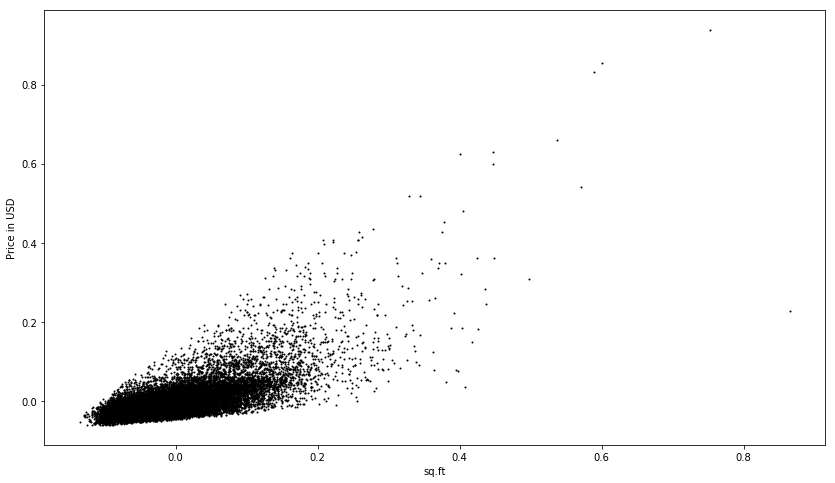

In [21]:
plt.plot(X, y, 'ro', ms=1, mec='k') # the parameters control the size, shape and color of the scatter plot
plt.ylabel('Price in USD')
plt.xlabel('sq.ft')
plt.show()

## Bias Trick

Make sure that `X` takes into consideration the bias $\theta_0$ in the linear model. Hint, recall that the predications of our linear model are of the form:

$$
\hat{y} = h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

Add columns of ones as the zeroth column of `X`. (2 points)

In [22]:
ones = np.ones_like(X)
X = np.vstack((ones, X)).T



## Part 2: Single Variable Linear Regression (40 Points)
Simple linear regression is a linear regression model with a single explanatory varaible and a single target value. 

$$
\hat{y} = h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

## Gradient Descent 

Our task is to find the best possible linear line that explains all the points in our dataset. We start by guessing initial values for the linear regression parameters $\theta$ and updating the values using gradient descent. 

The objective of linear regression is to minimize the cost function $J$:

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{n}(h_\theta(x^{(i)})-y^{(i)})^2
$$

where the hypothesis (model) $h_\theta(x)$ is given by a **linear** model:

$$
h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

$\theta_j$ are parameters of your model. and by changing those values accordingly you will be able to lower the cost function $J(\theta)$. One way to accopmlish this is to use gradient descent:

$$
\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
$$

In linear regresion, we know that with each step of gradient descent, the parameters $\theta_j$ get closer to the optimal values that will achieve the lowest cost $J(\theta)$.

Implement the cost function `compute_cost` in the python file `hw1.py`. (10 points)

In [23]:
theta = np.array([-1, 2])
J = compute_cost(X, y, theta)
# This is a basic test of your implementation.
print('✓''' if np.isclose(J, 0.5060823381358492, rtol=1e-08) else '✗')

✓


In [24]:
# Test your implementation #

Implement the gradient descent function `gradient_descent` in the python file `hw1.py` and run the following cell. (10 points)

In [25]:
np.random.seed(42)
theta = np.random.random(size=2)
iterations = 40000
alpha = 0.1
theta, J_history = gradient_descent(X ,y, theta, alpha, iterations)
# This is a basic test of your implementation.
print('✓' if np.isclose(theta, [0, 0.487640956], rtol=1e-08).all() else '✗')

✓


In [26]:
# Test your implementation #

You can evaluate the learning process by monitoring the loss as training progress. In the following graph, we visualize the loss as a function of the iterations. This is possible since we are saving the loss value at every iteration in the `J_history` array. This visualization might help you find problems with your code. Notice that since the network converges quickly, we are using logarithmic scale for the number of iterations. 

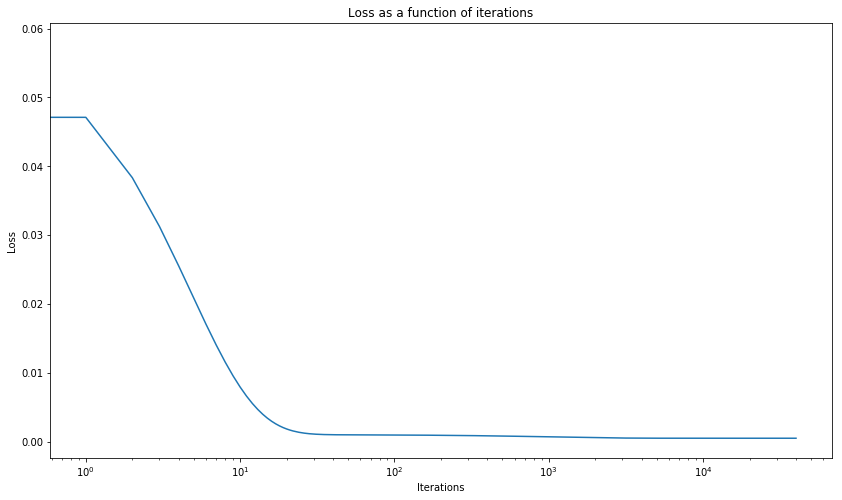

In [27]:
plt.plot(np.arange(iterations), J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.show()

Implement the psuedo-inverse function `pinv` in the python file `hw1.py`. **Do not use `np.pinv`**, instead use only direct matrix multicplication as you saw in class. (10 points)

In [28]:
theta_pinv = pinv(X,y)
J_pinv = compute_cost(X, y, theta_pinv)

# This is a basic test of your implementation.
print('✓' if np.isclose(J_pinv, 0.0005878100453257926, rtol=1e-08) else '✗')

✓


In [29]:
# Test your implementation #

We can add the loss value for the theta calculated using the psuedo-inverse to our graph. This is another sanity check as the loss of our model should converge to the psuedo-inverse loss.

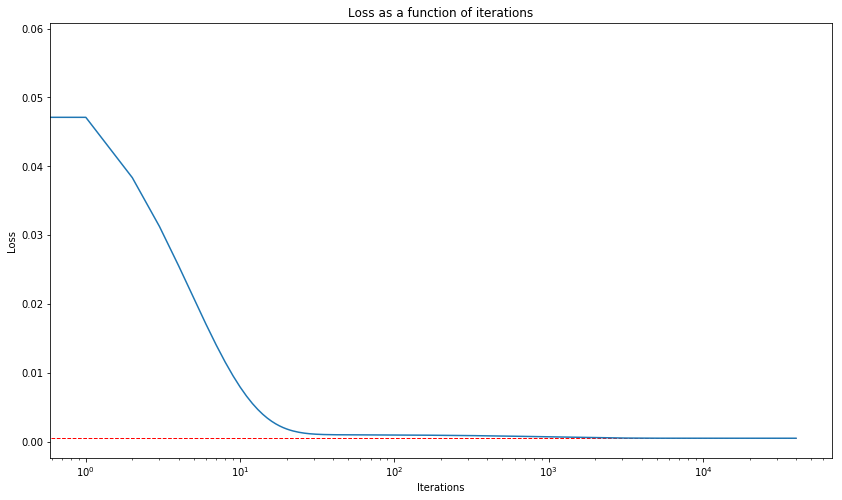

In [30]:
plt.plot(np.arange(iterations), J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.hlines(y = J_pinv, xmin = 0, xmax = len(J_history), color='r',
           linewidth = 1, linestyle = 'dashed')
plt.show()

We can use a better approach for the implementation of `gradient_descent`. Instead of performing 40,000 iterations, we wish to stop when the improvement of the loss value is smaller than `1e-8` from one iteration to the next. Implement the function `efficient_gradient_descent` in the python file `hw1.py`. (5 points)

In [36]:
np.random.seed(42)
theta = np.random.random(size=2)
iterations = 40000
alpha = 0.1
theta, J_history = efficient_gradient_descent(X ,y, theta, alpha, iterations)
# This is a basic test of your implementation.
print('✓' if np.isclose(theta, [0, 0.487640956], rtol=1e-08).all() else '✗')

✓


The learning rate is another factor that determines the performance of our model im terms of speed and accuracy. Complete the function `find_best_alpha` in the python file `hw1.py`. 

In [63]:
alpha_dict = find_best_alpha(X, y, 5)

Obtain the best learning rate from the dictionary `alpha_dict`. This can be done in several lines using built-in functions.

In [64]:
best_alpha = min(alpha_dict, key = lambda x: alpha_dict.get(x))

Pick the best three alpha values you just calculated and provide **one** graph with three lines indicating the loss as a function of iterations (Use 10,000 iterations). Note you are required to provide general code for this purpose (no hard-coding). Make sure the visualziation is clear and informative. (5 points)

[0.1, 0.03, 0.01]


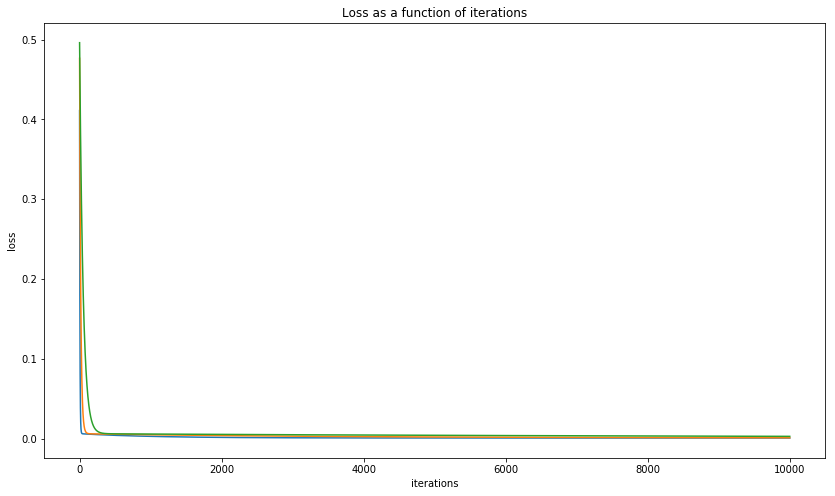

In [66]:
bestThreeAlphas = [best_alpha]
startingTheta = [-1, 2]
iterations = 10000

plt.ylabel('loss')
plt.xlabel('iterations')
plt.title('Loss as a function of iterations')

for i in range(2):
    alpha_dict.pop(best_alpha)
    best_alpha = min(alpha_dict, key = lambda x: alpha_dict.get(x))
    bestThreeAlphas.append(best_alpha)
    
print(bestThreeAlphas)
    
for alpha in bestThreeAlphas:
    J_history = efficient_gradient_descent(X, y, startingTheta, alpha, iterations)[1]
    plt.plot(np.arange(iterations), J_history)

This is yet another sanity check. This function plots the regression lines of your model and the model based on the pseudoinverse calculation. Both models should exhibit the same trend through the data. 

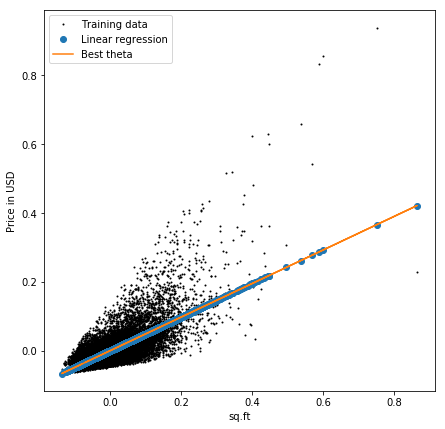

In [67]:
plt.figure(figsize=(7, 7))
plt.plot(X[:,1], y, 'ro', ms=1, mec='k')
plt.ylabel('Price in USD')
plt.xlabel('sq.ft')
plt.plot(X[:, 1], np.dot(X, theta), 'o')
plt.plot(X[:, 1], np.dot(X, theta_pinv), '-')

plt.legend(['Training data', 'Linear regression', 'Best theta']);

## Part 2: Multivariate Linear Regression (30 points)

In most cases, you will deal with databases that have more than one feature. It can be as little as two features and up to thousands of features. In those cases, we use a multiple linear regression model. The regression equation is almost the same as the simple linear regression equation:

$$
\hat{y} = h_\theta(\vec{x}) = \theta^T \vec{x} = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n
$$


If you wrote vectorized code, this part should be straightforward. If your code is not vectorized, you should go back and edit your functions such that they support both multivariate and single variable regression. **Your code should not check the dimensionality of the input before running**.

In [ ]:
# Read comma separated data
df = pd.read_csv('data/kc_house_data.csv')
df.head()

## Preprocessing

Like in the single variable case, we need to create a numpy array from the dataframe. Before doing so, we should notice that some of the features are clearly irrelevant. The features your should ignore are the `id` and `date`.

In [ ]:
X = None
y = None
# YOUR CODE HERE
raise NotImplementedError()

Use the **same** `preprocess` function you implemented in `hw1.py`. Notice that proper vectorized implementation should work regardless of the dimensionality of the input. You might want to check that your code in the previous part still works.

In [ ]:
# preprocessing
X, y = preprocess(X, y)

Using 3D visualization, we can still observe trends in the data. Visualizing additional dimensions requires advanced techniques we will learn later in the course.

In [ ]:
%matplotlib inline
import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure(figsize=(5,5))
ax = p3.Axes3D(fig)
xx = X[:, 1][:1000]
yy = X[:, 2][:1000]
zz = y[:1000]
ax.scatter(xx, yy, zz, marker='o')
ax.set_xlabel('bathrooms')
ax.set_ylabel('sqft_living')
ax.set_zlabel('price')
plt.show()

Use the bias trick again (add a column of ones as the zeroth column in `X`).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Make sure the functions `compute_cost` (10 points), `gradient_descent` (15 points), and `pinv` (5 points) work on the multi-dimensional dataset. If you make any changes, make sure your code still works on the single variable regression model. 

In [ ]:
shape = None
theta = np.ones(shape)
J = compute_cost(X, y, theta)

# This is a basic test of your implementation.
print('✓' if np.isclose(J, 0.8527637409800696, rtol=1e-08) else '✗')

In [ ]:
# Test your implementation #

In [ ]:
np.random.seed(42)
shape = X.shape[1]
theta = np.random.random(shape)
iterations = 40000
alpha = best_alpha
theta, J_history = gradient_descent(X ,y, theta, alpha, iterations)

In [ ]:
theta_pinv = pinv(X,y)
J_pinv = compute_cost(X, y, theta_pinv)

# This is a basic test of your implementation.
print('✓' if np.isclose(J_pinv, 0.0004473773610022496, rtol=1e-08) else '✗')

We can use visualization to make sure the code works well. Notice we use logarithmic scale for the number of iterations, since gradient descent converges after 500 iterations in this example

In [ ]:
plt.plot(np.arange(iterations), J_history)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations - multivariate linear regression')
plt.hlines(y = J_pinv, xmin = 0, xmax = len(J_history), color='r',
           linewidth = 1, linestyle = 'dashed')
plt.show()

## Part 3: Find best features for regression (20 points)

Adding additional features to our regression model makes it more complicated but does not necessarily improves performance. Find the combination of three features that best minimizes the loss. First, we will reload the dataset as a dataframe in order to access the feature names. Use the dataframe with the relevant features as the input to the `generate_triplets` and obtain a list of all possible feature triplets. (5 points)

In [ ]:
columns_to_drop = ['price', 'id', 'date']
all_features = df.drop(columns=columns_to_drop)
triplets = generate_triplets(all_features)

Complete the function `find_best_triplet` in the python file `hw1.py`. (10 points)

In [ ]:
%%time 
print(find_best_triplet(df, triplets, alpha=best_alpha, num_iter=20000))

Give an explanations to the results. Do they make sense? How could you further improve this linear regression model? (5 points)

In [ ]:
### Your answer here ###